[Table of Contents](./table_of_contents.ipynb)

# Discrete Bayes Filter

In [99]:
%matplotlib inline

In [100]:
#format the book
import book_format
import numpy as np
book_format.set_style()
import kf_book.book_plots as book_plots
from kf_book.book_plots import figsize, set_figsize
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

## Tracking
We want to track the location of Paco outside. We have sensors outside placed in 1m distances, and the sensors give us a reading of `1` if Paco is in front of grass, and `0` if he's not. We know the true layout of grasses outside. Let's simulate the outside layout:

Outside layout: [1 1 0 1 1 0 0 0 1 0]


Text(0.5, 1.0, 'Outside layout')

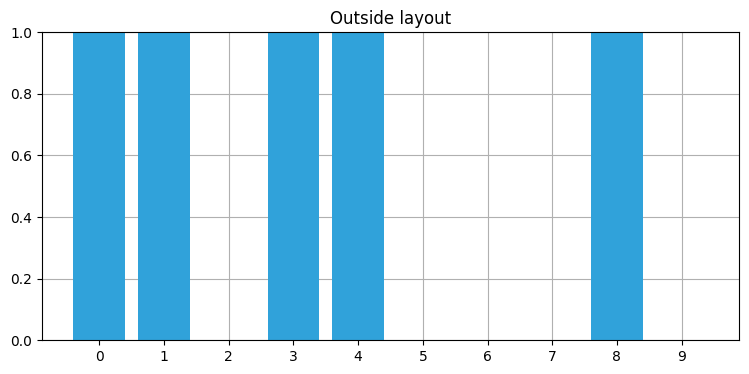

In [101]:
N = 10
# layout = np.random.randint(0, 2, N)
layout = np.array([1, 1, 0, 1, 1, 0, 0, 0, 1, 0])

N = len(layout)
print(f'Outside layout: {layout}')

book_plots.bar_plot(layout)
plt.title(f"Outside layout")

### The prior
At first if we have no idea where paco is, we start off with a prior assigning every location equal probability. Otherwise, we can have a more specific prior distribution if we know something about his initial location. Let's use:

```Python
location = [0.1, 0.1, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
```

Prior probabilities of Paco's location: [0.1 0.1 0.8 0.  0.  0.  0.  0.  0.  0. ]


Text(0.5, 1.0, "Prior of Paco's initial location")

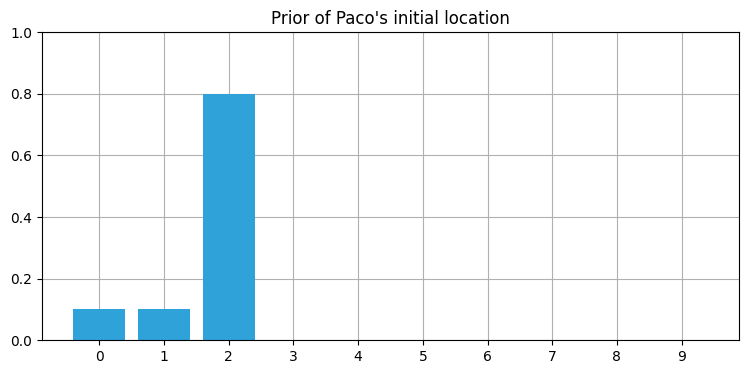

In [110]:
# Use this to reset later
location_0 = np.array([0.1, 0.1, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

location = location_0
print(f"Prior probabilities of Paco's location: {location}")

book_plots.bar_plot(location)
plt.title(f"Prior of Paco's initial location")

### The measurement and update
It is now 1 second later and we just got a sensor reading `z`. We want to use our sensor reading with our prior knowledge to come up with the current estimate of where Paco is. This is done by calculating the likehood of Paco's location given the sensor reading `z`, multiplying it by our prior belief of his location, and then normalizing the result to achieve a valid pmf of our updated belief of his current location.

First, let's just see what our likelihood function looks like for different values of `z` and `z_acc`. For a perfect sensor, `z_acc = 1.0`.

Text(0.5, 1.0, 'Likelihood for z=1 and z_acc=0.9')

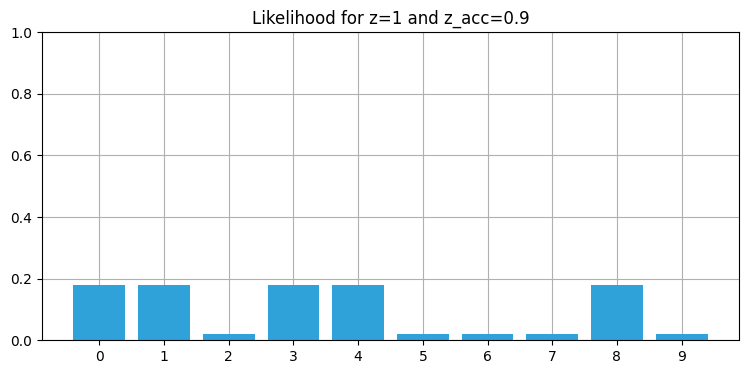

In [103]:
def get_l_of_z(layout, z, z_acc):
    # Start off with zero likelihood
    likelihood = np.ones(len(layout))

    # Set likelihoods of all locations equal to our sensor reading equal to the sensor accuracy
    likelihood[layout == z] = z_acc

    # And likelihoods of all locations not equal to our sensor reading equal to 1 - sensor accuracy
    likelihood[layout != z] = 1 - z_acc

    # Noramlize and return
    return likelihood / sum(likelihood)

    

# Try out different readings and reading accuracies and see the resulting likelihood of Paco's location
# For example, notice how z=0,z_acc=0.9 is equivalent to z=1,z_acc=0.1, and how z_acc=0.5 gives us nothing useful
z = 1
z_acc = 0.9

book_plots.bar_plot(get_l_of_z(layout, z, z_acc))
plt.title(f'Likelihood for z={z} and z_acc={z_acc}')

Again, the above is the location likelihood we would get given a new reading `z` with assumed or known accuracy of `z_acc`. If we only wanted to trust our sensors, we would just use this for our current location estimate. But if we want to combine our sensor readings with prior beliefs, we have to combine them. In the case of discrete bayes, we will treat them equally. 

Let's say that Paco actually IS at location `2` in accordance with our highest initial prior probability. And that he is moving 1 m/s to the right, and we get one reading per second. In this case, if we got all correct sensor readings, our next 6 measurements would be

```Python
zs = [1, 1, 0, 0, 0, 1]
```

and Paco would be at location 8.

Let's see what would happen to our updated estimates of Paco's location, starting with our prior initial location pmf and these 6 measurements:

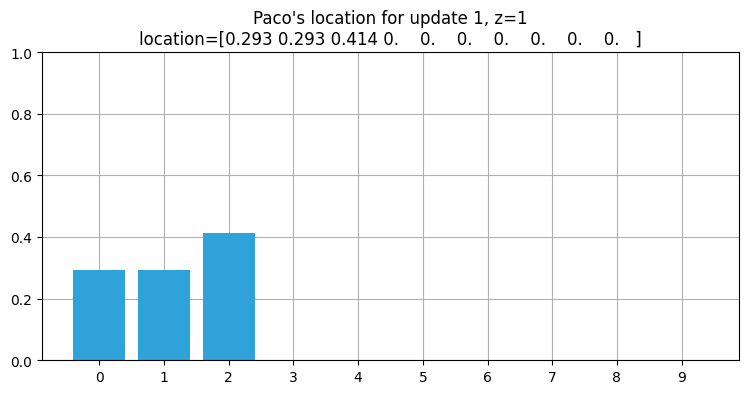

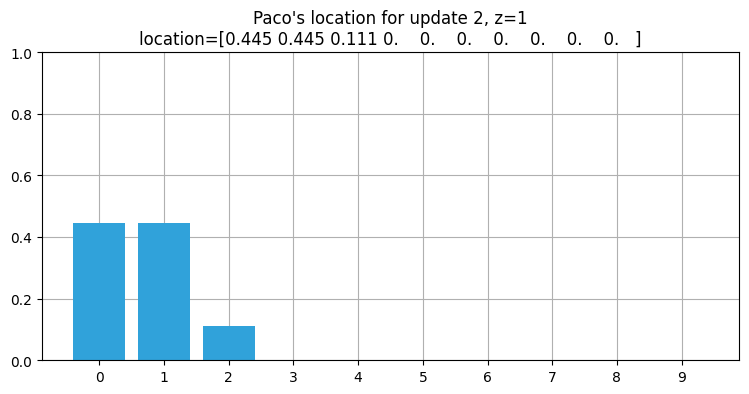

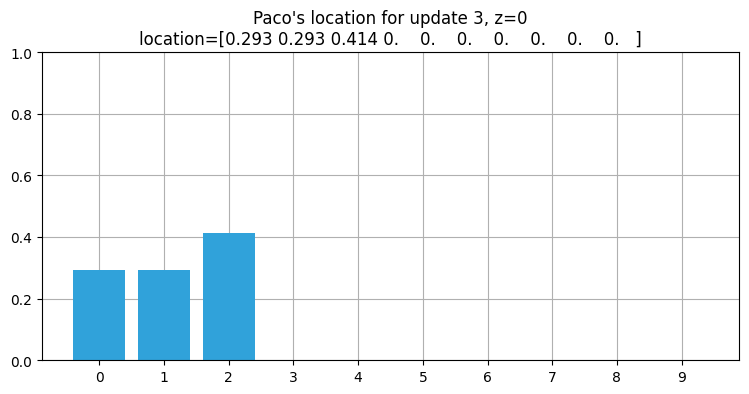

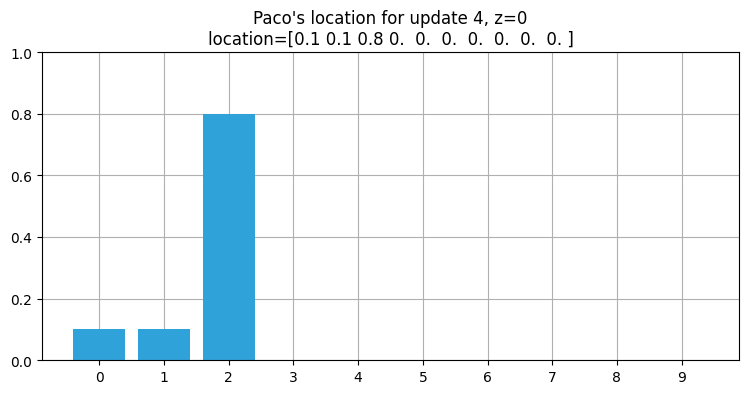

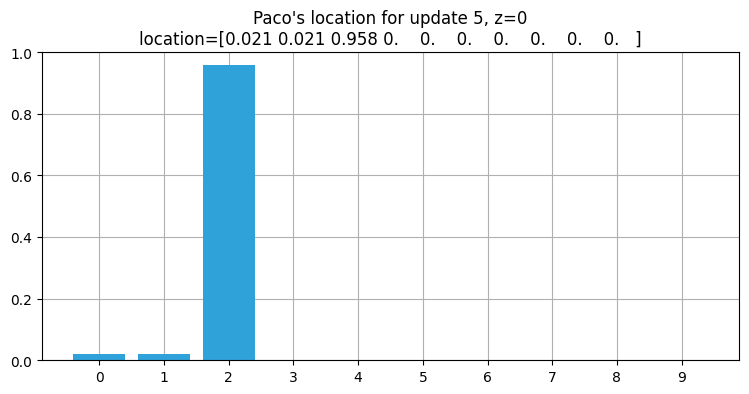

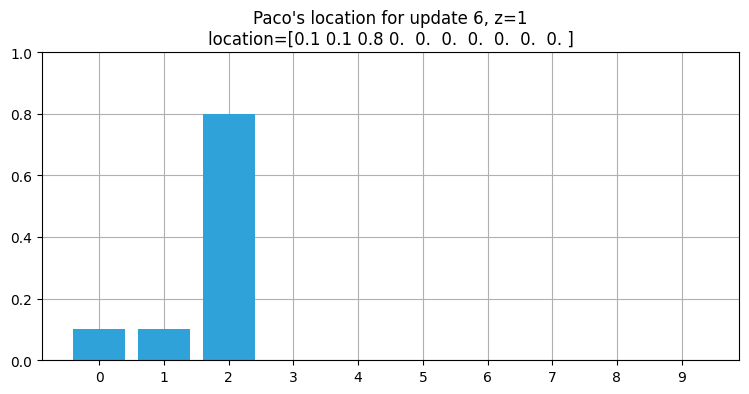

In [111]:
def update(likelihood, prior):
    loc_new = likelihood * prior
    return loc_new / sum(loc_new)

location = location_0
z_acc = 0.85
zs = [1, 1, 0, 0, 0, 1]
for i, z in enumerate(zs):
    location = update(get_l_of_z(layout, z, z_acc), location)

    plt.figure()
    book_plots.bar_plot(location)
    plt.title(f"Paco's location for update {i+1}, z={z}\nlocation={location}")

Because we have an equal number of `z=1` and `z=0` after 6 measurements, we just end up with the original prior distribution. Even though Paco is actually at location 8, we are way off and have returned back to our original estimated location pmf. Why?

We are missing incorportating a _dynamic process_ and a _prediction_ into our future priors!

### Prediction

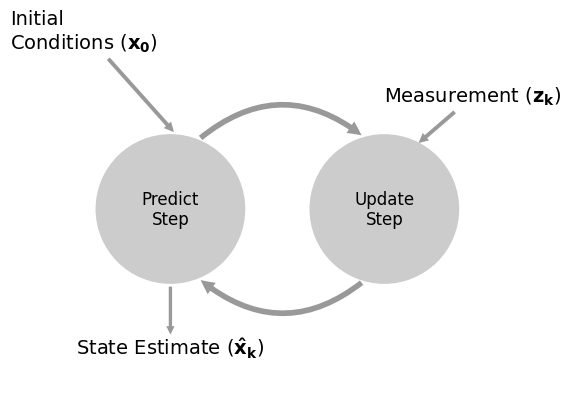

In [105]:
book_plots.predict_update_chart()

Above, by not using a dynamic process model, we are essentially "predicting" that the next location will be the same location, i.e. Paco is not moving. If we assume this is true, then the location estimates at each step above actually make sense, and are influenced ONLY by the initial location and the sensor readings we get (go back and check why this is true)! 

So we basically have this:

$$\begin{aligned} \bar {\mathbf x} &= \mathbf x \, \, &\text{Predict Step} \\
\mathbf x &= \|\mathcal L \cdot \bar{\mathbf x}\|\, \, &\text{Update Step}\end{aligned}$$

This clearly isn't enough information to track Paco. What we need to do is incorporate a model of his movement into our predictions. So we actually want this:

$$\begin{aligned} \bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{Predict Step} \\
\mathbf x &= \|\mathcal L \cdot \bar{\mathbf x}\|\, \, &\text{Update Step}\end{aligned}$$

Where $f_x(\bullet)$ is the pmf for how Paco moves. So to get our next predicted pmf of his location, we convolve our current estimated pmf with the predicted movement pmf. For example, if we are confident he moves exactly 1m/s to the right, $f_x(\bullet) = \delta[n-1]$. This has the effect of shifting our current pmf exactly one spot to the right for our prediction. If we are confident he moves exactly 2m/s to the right, $f_x(\bullet) = \delta[n-2]$. If we are not confident in his exact speed or direction, we have some other pmf we define.

Let's say we're pretty confident that Paco is moving to the right at 1m/s, but could also be staying put or moving to the left at 1m/s. Then $f_x = [0.1, 0.1, 0.8]$, centered at zero. For whatever reason, using scipy.image.convolve doesn't require us to shift anything to make the filter non-causal?

Let's see what we would predict for our first step:

Text(0.5, 1.0, "Paco's predicted location for one step with movement pmf [0.1 0.1 0.8]")

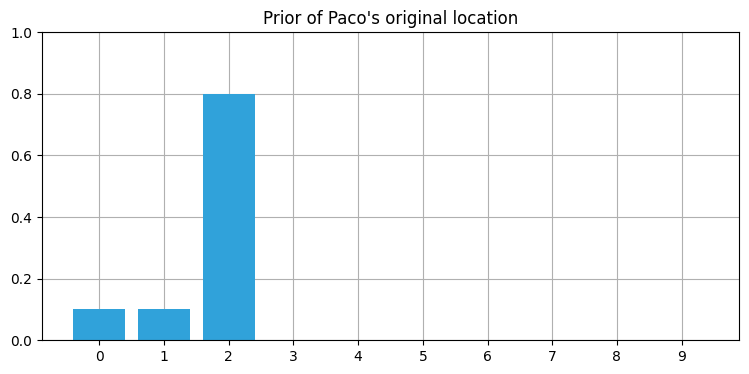

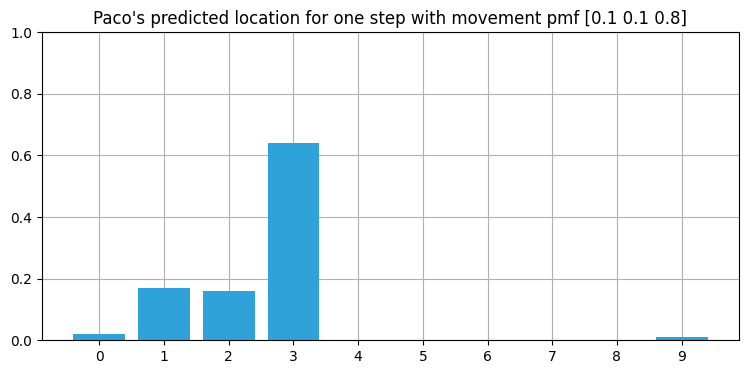

In [106]:
def predict(prior, movement):
    return convolve(prior, movement, mode='wrap')

movement = np.array([0.1, 0.1, 0.8])
# bla = np.array([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
bla = location_0
new_loc = predict(bla, movement)

plt.figure()
book_plots.bar_plot(bla)
plt.title(f"Prior of Paco's original location")

plt.figure()
book_plots.bar_plot(new_loc)
plt.title(f"Paco's predicted location for one step with movement pmf {movement}")

### The correct flow
Let's see what happens if we incorporate our dynamic process model with our sensor readings. Again, assuming that all readings are correct:

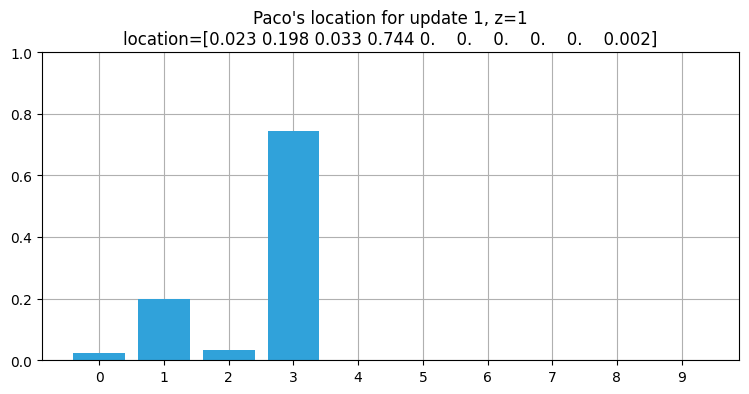

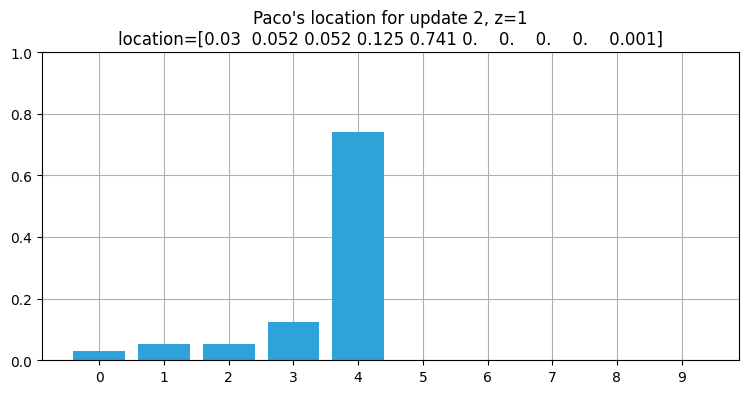

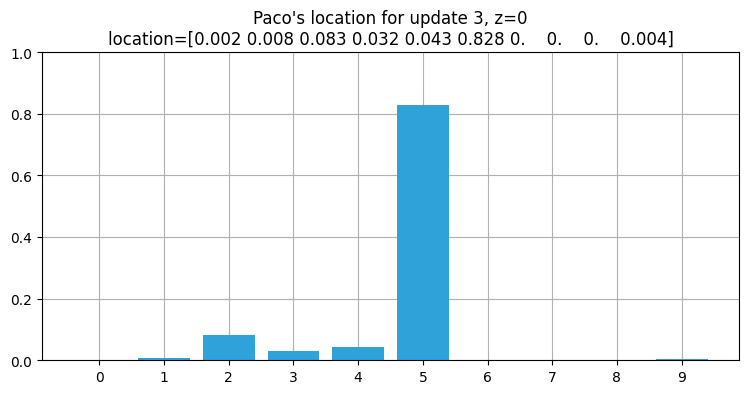

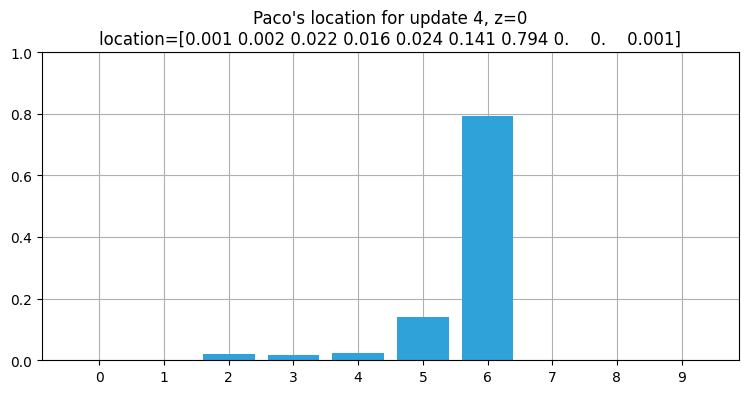

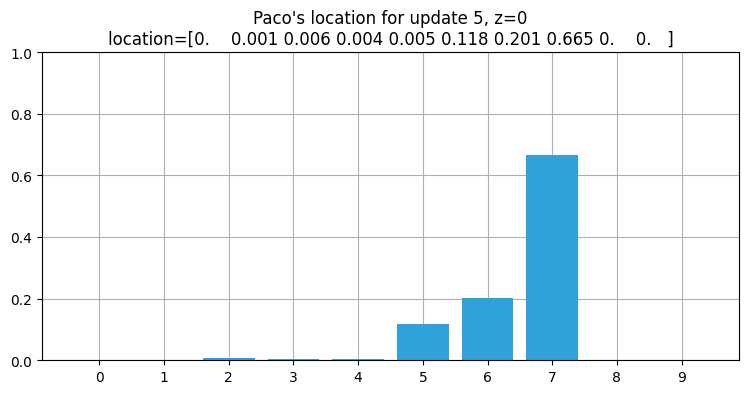

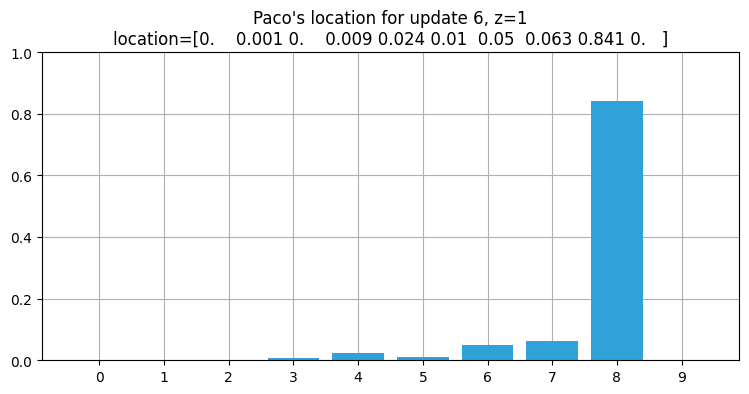

In [107]:
def full_epoch(prior, movement, layout, z, z_acc):
    # Make prediction of current location pmf from prior
    curr_loc = predict(prior, movement)

    # Get likelihood of locations from current reading
    curr_like = get_l_of_z(layout, z, z_acc)

    # Update the state based on the above two
    return update(curr_like, curr_loc)


location = location_0
movement = np.array([0.1, 0.1, 0.8])

z_acc = 0.85
zs = [1, 1, 0, 0, 0, 1]
for i, z in enumerate(zs):
    location = full_epoch(location, movement, layout, z, z_acc)

    plt.figure()
    book_plots.bar_plot(location)
    plt.title(f"Paco's location for update {i+1}, z={z}\nlocation={location}")
    

Looks correct!! What about if one of our first sensor readings was actually wrong?

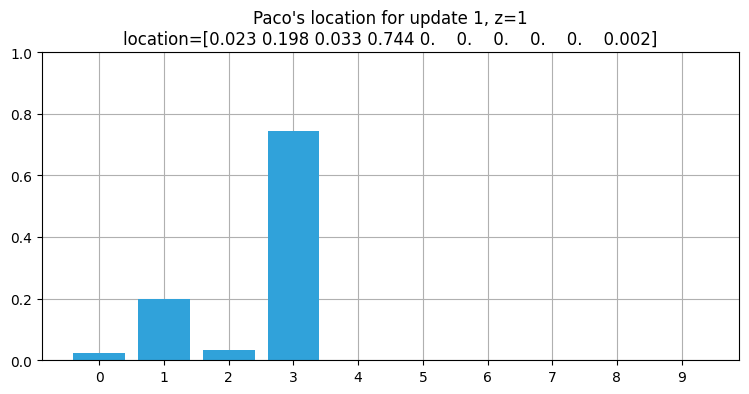

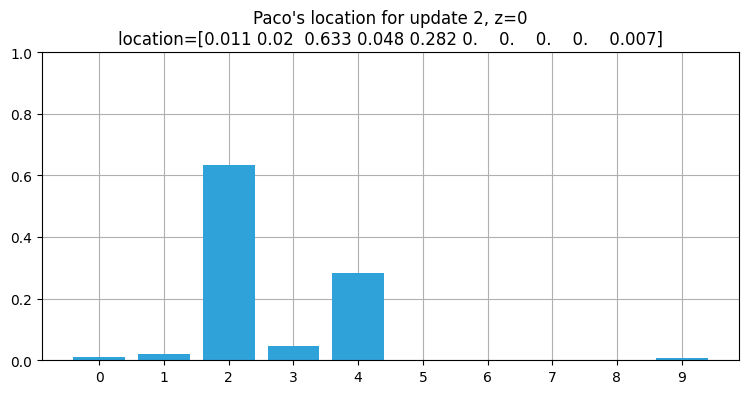

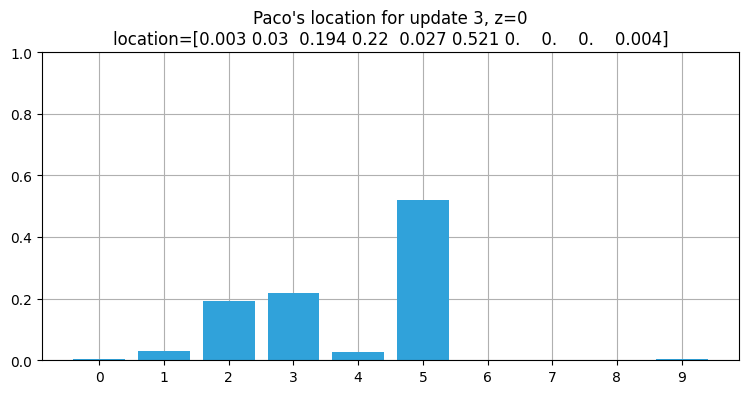

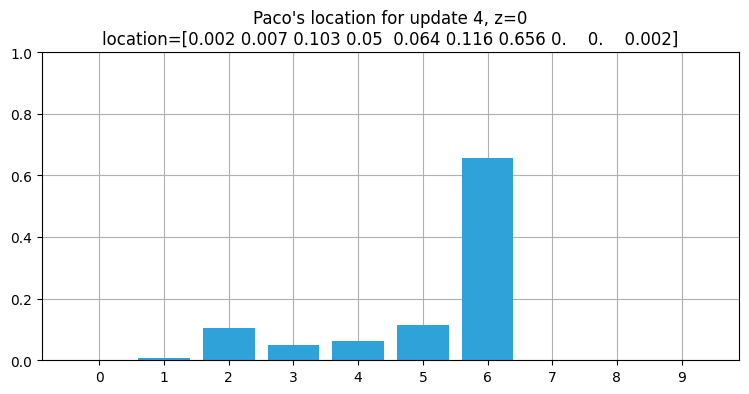

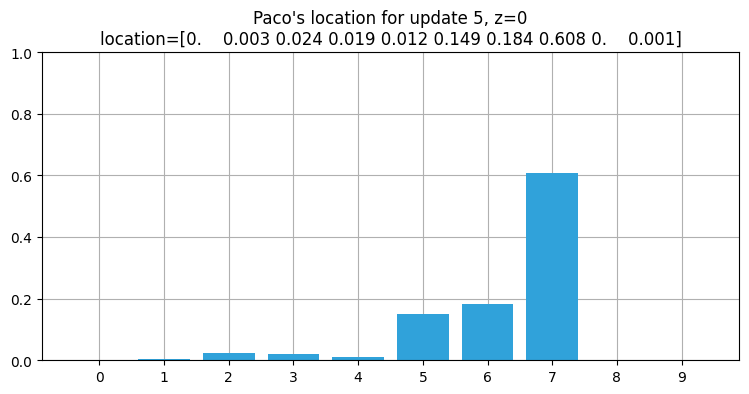

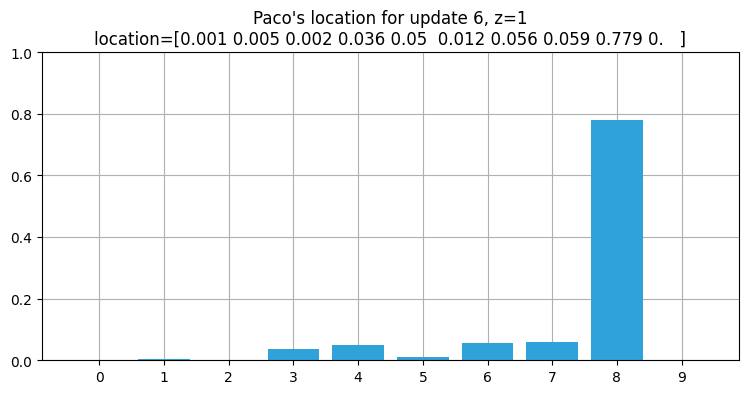

In [108]:
location = location_0
zs = [1, 0, 0, 0, 0, 1] # second reading is WRONG!
for i, z in enumerate(zs):
    location = full_epoch(location, movement, layout, z, z_acc)

    plt.figure()
    book_plots.bar_plot(location)
    plt.title(f"Paco's location for update {i+1}, z={z}\nlocation={location}")

We end up with an incorrect distribution at update 2, but by update 6 we are back on track!